# open FIA data points

In [ ]:
from glob import glob
import pandas as pd
import geopandas as gpd
import ee
import numpy as np
from shapely.geometry import Point, Polygon
import folium
from folium.plugins import MarkerCluster
import binascii
import os
import sys
sys.path.append('/content')
from src.tools import Mapdisplay, random_point_in_shp
from src.tools import get_bound_points, generate_box_buffer, generate_ee_points
import src.tools as tools

ee.Initialize()
%matplotlib inline

# Standard packages
import tempfile
import warnings
import urllib
import shutil
import os

# Workaround for a problem in older rasterio versions
os.environ["CURL_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt" 

# Less standard, but still pip- or conda-installable
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rtree
import shapely
import pickle

# pip install progressbar2, not progressbar
import progressbar

from geopy.geocoders import Nominatim
from rasterio.windows import Window 
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

from src.azuretools import *

latest_wkid = 3857
crs = "EPSG:4326"

# Storage locations are documented at http://aka.ms/ai4edata-naip
blob_root = 'https://naipblobs.blob.core.windows.net/naip'

index_files = ["tile_index.dat", "tile_index.idx", "tiles.p"]
index_blob_root = 'https://naipblobs.blob.core.windows.net/naip-index/rtree/'
temp_dir = os.path.join(tempfile.gettempdir(),'naip')
os.makedirs(temp_dir,exist_ok=True)

# Spatial index that maps lat/lon to NAIP tiles; we'll load this when we first 
# need to access it.
index = None
if index is None:
    index = NAIPTileIndex()
# URL where we've stashed a geojson file with the boundaries of Maryland.  Why do we
# need the boundaries of Maryland?  It's a surprise, you'll have to keep reading to find
# out.
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
fiafile = '/datadrive/fia/PNWRS_Annualized_Inventory_ActCoordinates_ChangMTA_200731.csv'
plots = gpd.GeoDataFrame(pd.read_csv(fiafile))
plots.rename(columns={'ACTUAL_LAT':'LAT','ACTUAL_LON':'LON'}, inplace=True)
plots.Latitude = plots.LAT.astype('float')
plots.Longitude = plots.LON.astype('float')
geometry = [Point(xy) for xy in zip(plots.Longitude, plots.Latitude)]
crs = {'init': 'epsg:4326'} 
geo_df = gpd.GeoDataFrame(plots, crs=crs, geometry=geometry)

#subset by STATECD
statecd = pd.read_csv(glob('/datadrive/fia/supp_data/*.csv')[0])
query = 'CA'

code = statecd[statecd['STATEAB']== query]['STATECD'].values[0]
subdf = geo_df[geo_df['STATECD']==code]
fields = ['PLT_CN', 'INVYR', 'LAT', 'LON']
subdf = subdf.rename(columns={'ACTUAL_LAT':'LAT', 'ACTUAL_LON':'LON'})[fields]
subdf = subdf.astype({'LAT':'float', 'LON':'float', 'INVYR':'int32'})
subdf = gpd.GeoDataFrame(subdf, geometry=gpd.points_from_xy(subdf.LON, subdf.LAT))
subdf = subdf.set_crs(epsg=4326)

#statebounds for reducing query on cloud
statebounds = glob('/datadrive/fia/supp_data/stateboundaries/*.shp')[0]
states = gpd.read_file(statebounds)
state = states[states['STPOSTAL']==query]
state_shape = state.geometry

In [ ]:
from pathlib import Path
from PIL import Image
import fiona
import fiona.transform
import requests
import json

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

flatten = lambda l: [item for sublist in l for item in sublist]

####################################

ref_list = []
skip_list = []
batch_size = 50 
for batch_number, sample in enumerate(chunker(subdf, batch_size)):

    image_crops = [] # place to save the images we grab
    image_points = [] # place to save the lat/lons
    image_skips = []
    ids = []
    year_selected = []
    ref = []
    for i, (_,point) in tqdm(enumerate(sample.iterrows()),total=len(sample)):

        lon, lat = point.geometry.x, point.geometry.y

        # Find the filenames that intersect with our lat/lon
        naip_files = index.lookup_tile(lat, lon) 

        if naip_files is None or len(naip_files) == 0:
            print('No intersection, skipping point {}'.format(i))
            image_skips.append(i)
            ref.append('None')
            continue

        # check for the matching or closest year
        query_year = point.INVYR
        naip_years = np.array([int(n.split('/')[2]) for n in naip_files])
        closest = min(naip_years, key=lambda x:abs(x-query_year))
        year_selected.append(closest)
        match_idx = np.where(naip_years==closest)[0][0]

        image_url = blob_root + '/' + naip_files[match_idx] 

        with rasterio.open(image_url) as f:

            # Each NAIP tile has its own coordinate system that is *not* lat/lon 
            crs = f.crs 

            # This object will let us convert between tile coordinates (these will be local
            # state CRS) and tile offsets (i.e. pixel indices)
            transform = f.transform 

            # Convert our lat/lon point to the local NAIP coordinate system
            x_tile_crs, y_tile_crs = fiona.transform.transform("epsg:4326",\
                                                               crs.to_string(),\
                                                               [lon],[lat]) 
            x_tile_crs = x_tile_crs[0]
            y_tile_crs = y_tile_crs[0]

            # Convert our new x/y coordinates into pixel indices
            x_tile_offset, y_tile_offset = ~transform * (x_tile_crs, y_tile_crs) 
            x_tile_offset = int(np.floor(x_tile_offset))
            y_tile_offset = int(np.floor(y_tile_offset))        

            # The secret sauce: only read data from a 256x256 window centered on our point
            image_crop = f.read(window=Window(x_tile_offset-128, y_tile_offset-128, 256, 256)) 
            image_crop = np.rollaxis(image_crop, 0, 3)

        # Sometimes our point will be on the edge of a NAIP tile, and our windowed reader above
        # will not actually return a 256x256 chunk of data we could handle this nicely by going 
        # back up to the `naip_files` list and trying to read from one of the other tiles - 
        # because the NAIP tiles have overlap with one another, there should exist an intersecting
        # tile with the full window.
        if (image_crop.shape[0] == 256) and (image_crop.shape[1] == 256):
            image_crops.append(image_crop)
            image_points.append(point)
            ref.append(image_url)
        else:
            print('Our crop was likely at the edge of a NAIP tile, skipping point {}'.format(i))
            image_skips.append(i)
            ref.append('None')
    # ...for each point
    #now we want to save the images in a directory
    labels = [s.PLT_CN for i,(_,s) in enumerate(sample.iterrows()) if i not in image_skips]
    ref_data = [r for i,r in enumerate(ref) if i not in image_skips] 
    dataset = 'NAIP'
    write_dirc = f'/datadrive/fia/training_tiles/{dataset}/{query}'
    Path(write_dirc).mkdir(parents=True, exist_ok=True)
    for i,l in enumerate(labels):
        outfile = f'{write_dirc}/{l}.tif'
        outimage = Image.fromarray(image_crops[i][:,:,:3]) 
        outimage.save(outfile)
    ref_list.append(ref)
    skip_list.append(image_skips)
    
ref_urls = flatten(ref_list)
outname = f'/datadrive/fia/training_tiles/{dataset}/{query}_urls.csv'
subdf[['PLT_CN','INVYR', 'REF_URL']].to_csv(outname, index='False')

  6%|▌         | 3/50 [00:01<00:26,  1.78it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 4


 24%|██▍       | 12/50 [00:06<00:23,  1.61it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 11


 38%|███▊      | 19/50 [00:10<00:16,  1.84it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 18


 86%|████████▌ | 43/50 [00:26<00:04,  1.40it/s]

No tile intersections
No intersection, skipping point 43


 38%|███▊      | 19/50 [01:36<02:20,  4.52s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 18


 64%|██████▍   | 32/50 [02:32<01:23,  4.62s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 31


 78%|███████▊  | 39/50 [03:10<01:00,  5.46s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 38


 26%|██▌       | 13/50 [01:01<02:55,  4.75s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 12


 38%|███▊      | 19/50 [01:28<02:17,  4.44s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 18


 78%|███████▊  | 39/50 [03:06<00:57,  5.23s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 38


 86%|████████▌ | 43/50 [03:24<00:32,  4.69s/it]

No tile intersections
No intersection, skipping point 43


 68%|██████▊   | 34/50 [02:54<01:14,  4.64s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 33


 14%|█▍        | 7/50 [00:45<04:31,  6.31s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 6


 88%|████████▊ | 44/50 [03:36<00:28,  4.68s/it]

No tile intersections
No intersection, skipping point 44


 30%|███       | 15/50 [01:17<02:58,  5.10s/it]

No tile intersections
No intersection, skipping point 15


 34%|███▍      | 17/50 [01:23<02:28,  4.49s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 16


 60%|██████    | 30/50 [02:33<01:58,  5.91s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 29


 60%|██████    | 30/50 [02:40<01:56,  5.84s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 29


 98%|█████████▊| 49/50 [04:36<00:05,  5.01s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 48


 56%|█████▌    | 28/50 [02:16<02:04,  5.64s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 27


 58%|█████▊    | 29/50 [02:21<01:55,  5.51s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 28


 22%|██▏       | 11/50 [01:18<04:09,  6.40s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 10


 34%|███▍      | 17/50 [01:40<02:23,  4.35s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 16


 16%|█▌        | 8/50 [00:44<04:18,  6.15s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 7


 40%|████      | 20/50 [01:42<01:57,  3.91s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 19


 80%|████████  | 40/50 [02:57<00:48,  4.89s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 39


  4%|▍         | 2/50 [00:08<03:20,  4.18s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 1


 26%|██▌       | 13/50 [01:04<03:18,  5.36s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 12


 32%|███▏      | 16/50 [01:20<03:02,  5.37s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 15


  8%|▊         | 4/50 [00:19<03:51,  5.03s/it]

No tile intersections
No intersection, skipping point 4


 14%|█▍        | 7/50 [00:33<03:27,  4.83s/it]

No tile intersections
No intersection, skipping point 7


 20%|██        | 10/50 [00:42<02:49,  4.24s/it]

No tile intersections
No intersection, skipping point 10


 30%|███       | 15/50 [01:05<02:58,  5.09s/it]

No tile intersections
No intersection, skipping point 15


 40%|████      | 20/50 [01:28<02:49,  5.66s/it]

No tile intersections
No intersection, skipping point 20


 44%|████▍     | 22/50 [01:33<02:11,  4.68s/it]

No tile intersections
No intersection, skipping point 22
No tile intersections
No intersection, skipping point 23
No tile intersections
No intersection, skipping point 24


 52%|█████▏    | 26/50 [01:41<01:34,  3.93s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 25


 54%|█████▍    | 27/50 [01:47<01:45,  4.60s/it]

No tile intersections
No intersection, skipping point 27


 60%|██████    | 30/50 [01:58<01:23,  4.19s/it]

No tile intersections
No intersection, skipping point 30


  2%|▏         | 1/50 [00:04<03:25,  4.19s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 0


  4%|▍         | 2/50 [00:08<03:24,  4.26s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 1


 18%|█▊        | 9/50 [00:38<02:59,  4.37s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 8


  0%|          | 0/50 [00:00<?, ?it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 49


 80%|████████  | 40/50 [03:11<00:48,  4.80s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 39


 36%|███▌      | 18/50 [01:27<03:35,  6.73s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 17


 46%|████▌     | 23/50 [01:54<02:24,  5.35s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 22


 42%|████▏     | 21/50 [01:40<02:18,  4.77s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 20


 46%|████▌     | 23/50 [01:50<02:05,  4.64s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 22


 72%|███████▏  | 36/50 [02:54<01:08,  4.86s/it]

No tile intersections
No intersection, skipping point 36
No tile intersections
No intersection, skipping point 37


 96%|█████████▌| 48/50 [03:41<00:09,  4.60s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 47


 60%|██████    | 30/50 [02:40<01:51,  5.59s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 29


 64%|██████▍   | 32/50 [02:49<01:31,  5.06s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 31


 40%|████      | 20/50 [01:34<02:18,  4.63s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 19


 52%|█████▏    | 26/50 [02:06<02:03,  5.14s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 25


 86%|████████▌ | 43/50 [03:28<00:30,  4.34s/it]

No tile intersections
No intersection, skipping point 43


 98%|█████████▊| 49/50 [03:47<00:03,  3.71s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 48


 10%|█         | 5/50 [00:46<06:53,  9.18s/it]

No tile intersections
No intersection, skipping point 5


 26%|██▌       | 13/50 [01:28<04:08,  6.72s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 12


 46%|████▌     | 23/50 [02:10<02:01,  4.50s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 22


 66%|██████▌   | 33/50 [03:00<01:21,  4.79s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 32


 82%|████████▏ | 41/50 [03:30<00:32,  3.62s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 40


 18%|█▊        | 9/50 [00:43<03:34,  5.24s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 8


 96%|█████████▌| 48/50 [04:23<00:12,  6.08s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 47


 16%|█▌        | 8/50 [00:38<03:22,  4.82s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 7


 72%|███████▏  | 36/50 [02:44<01:02,  4.47s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 35


 80%|████████  | 40/50 [03:12<00:48,  4.80s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 39


 46%|████▌     | 23/50 [01:56<02:21,  5.24s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 22


 50%|█████     | 25/50 [02:06<02:05,  5.01s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 24


 14%|█▍        | 7/50 [00:35<03:31,  4.91s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 6


 70%|███████   | 35/50 [02:38<00:50,  3.36s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 34


 94%|█████████▍| 47/50 [03:58<00:16,  5.38s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 46


 32%|███▏      | 16/50 [01:24<02:40,  4.74s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 15


 14%|█▍        | 7/50 [00:12<01:35,  2.21s/it]

No tile intersections
No intersection, skipping point 7


 62%|██████▏   | 31/50 [01:49<01:03,  3.34s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 30


 88%|████████▊ | 44/50 [02:45<00:21,  3.57s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 43


  4%|▍         | 2/50 [00:05<01:45,  2.19s/it]

No tile intersections
No intersection, skipping point 2
No tile intersections
No intersection, skipping point 3


 18%|█▊        | 9/50 [00:25<02:45,  4.03s/it]

No tile intersections
No intersection, skipping point 9


 22%|██▏       | 11/50 [00:29<02:15,  3.47s/it]

No tile intersections
No intersection, skipping point 11
No tile intersections
No intersection, skipping point 12


 30%|███       | 15/50 [00:43<02:33,  4.40s/it]

No tile intersections
No intersection, skipping point 15


 88%|████████▊ | 44/50 [02:41<00:22,  3.70s/it]

No tile intersections
No intersection, skipping point 44


  0%|          | 0/50 [00:00<?, ?it/s]

No tile intersections
No intersection, skipping point 47
No tile intersections
No intersection, skipping point 48
No tile intersections
No intersection, skipping point 49
No tile intersections
No intersection, skipping point 0


  4%|▍         | 2/50 [00:04<01:38,  2.04s/it]

No tile intersections
No intersection, skipping point 2


 14%|█▍        | 7/50 [00:27<03:12,  4.47s/it]

No tile intersections
No intersection, skipping point 7
No tile intersections
No intersection, skipping point 8


 24%|██▍       | 12/50 [00:36<01:46,  2.80s/it]

No tile intersections
No intersection, skipping point 12


 50%|█████     | 25/50 [01:31<01:53,  4.53s/it]

No tile intersections
No intersection, skipping point 25


 54%|█████▍    | 27/50 [01:35<01:26,  3.77s/it]

No tile intersections
No intersection, skipping point 27
No tile intersections
No intersection, skipping point 28


 70%|███████   | 35/50 [01:57<00:53,  3.58s/it]

No tile intersections
No intersection, skipping point 35


 78%|███████▊  | 39/50 [02:16<00:48,  4.43s/it]

No tile intersections
No intersection, skipping point 39


 88%|████████▊ | 44/50 [02:30<00:21,  3.52s/it]

No tile intersections
No intersection, skipping point 44


  2%|▏         | 1/50 [00:04<03:33,  4.37s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 0


 16%|█▌        | 8/50 [00:31<02:07,  3.05s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 7


 32%|███▏      | 16/50 [01:02<01:47,  3.16s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 15


 60%|██████    | 30/50 [01:56<01:18,  3.92s/it]

No tile intersections
No intersection, skipping point 30


 36%|███▌      | 18/50 [01:09<02:10,  4.07s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 17


 36%|███▌      | 18/50 [01:16<02:40,  5.01s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 17


  6%|▌         | 3/50 [00:18<05:26,  6.95s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 2


 80%|████████  | 40/50 [02:49<00:42,  4.25s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 39


 94%|█████████▍| 47/50 [03:19<00:15,  5.10s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 46


 98%|█████████▊| 49/50 [03:34<00:06,  6.29s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 48


 52%|█████▏    | 26/50 [01:43<01:16,  3.18s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 25


 68%|██████▊   | 34/50 [02:22<01:14,  4.65s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 33


  2%|▏         | 1/50 [00:04<03:32,  4.34s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 0


 74%|███████▍  | 37/50 [04:32<02:51, 13.23s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 36


 80%|████████  | 40/50 [04:49<01:20,  8.04s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 39


 52%|█████▏    | 26/50 [02:04<01:58,  4.93s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 25


 58%|█████▊    | 29/50 [02:41<02:53,  8.25s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 28


  8%|▊         | 4/50 [00:32<07:08,  9.31s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 3


 10%|█         | 5/50 [00:38<06:04,  8.10s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 4


  6%|▌         | 3/50 [00:08<01:49,  2.32s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 2


 72%|███████▏  | 36/50 [02:31<01:03,  4.51s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 35


 12%|█▏        | 6/50 [00:23<02:40,  3.64s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 5


 58%|█████▊    | 29/50 [02:03<01:33,  4.44s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 28


  6%|▌         | 3/50 [00:09<02:31,  3.22s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 2


 10%|█         | 5/50 [00:21<03:33,  4.75s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 4


 52%|█████▏    | 26/50 [01:52<02:03,  5.13s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 25


 82%|████████▏ | 41/50 [02:53<00:40,  4.48s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 40


 12%|█▏        | 6/50 [00:26<03:23,  4.64s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 5


 38%|███▊      | 19/50 [01:22<02:15,  4.37s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 18


 64%|██████▍   | 32/50 [02:27<02:14,  7.47s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 31


 86%|████████▌ | 43/50 [03:10<00:29,  4.27s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 42


 16%|█▌        | 8/50 [00:43<03:40,  5.24s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 7


 42%|████▏     | 21/50 [01:26<01:20,  2.76s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 20


 30%|███       | 15/50 [01:07<03:31,  6.05s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 14


 82%|████████▏ | 41/50 [02:58<00:33,  3.74s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 40


 48%|████▊     | 24/50 [01:28<01:38,  3.79s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 23


  2%|▏         | 1/50 [00:00<00:33,  1.48it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 0


 64%|██████▍   | 32/50 [05:11<00:43,  2.42s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 31


 78%|███████▊  | 39/50 [05:28<00:21,  1.97s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 38


 10%|█         | 5/50 [00:20<03:24,  4.55s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 4


 72%|███████▏  | 36/50 [02:22<00:59,  4.22s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 35


 88%|████████▊ | 44/50 [03:05<00:34,  5.81s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 43


 92%|█████████▏| 46/50 [03:15<00:21,  5.38s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 45


 94%|█████████▍| 47/50 [03:49<00:12,  4.28s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 46


 60%|██████    | 30/50 [02:07<00:50,  2.51s/it]

No tile intersections
No intersection, skipping point 30


 80%|████████  | 40/50 [02:49<00:32,  3.30s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 39


 86%|████████▌ | 43/50 [03:03<00:29,  4.21s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 42


 32%|███▏      | 16/50 [01:06<01:45,  3.11s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 15


 76%|███████▌  | 38/50 [02:48<01:12,  6.02s/it]

No tile intersections
No intersection, skipping point 38
No tile intersections
No intersection, skipping point 39


 82%|████████▏ | 41/50 [02:48<00:38,  4.26s/it]

No tile intersections
No intersection, skipping point 41
No tile intersections
No intersection, skipping point 42


 88%|████████▊ | 44/50 [02:49<00:18,  3.04s/it]

No tile intersections
No intersection, skipping point 44


 94%|█████████▍| 47/50 [02:57<00:09,  3.17s/it]

No tile intersections
No intersection, skipping point 47
No tile intersections
No intersection, skipping point 48


  2%|▏         | 1/50 [00:04<03:21,  4.11s/it]

No tile intersections
No intersection, skipping point 1


 26%|██▌       | 13/50 [00:44<01:39,  2.69s/it]

No tile intersections
No intersection, skipping point 13


 84%|████████▍ | 42/50 [02:30<00:42,  5.33s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 41


  0%|          | 0/50 [00:00<?, ?it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 49


 28%|██▊       | 14/50 [00:59<02:30,  4.18s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 13


 74%|███████▍  | 37/50 [02:38<00:55,  4.26s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 36


 90%|█████████ | 45/50 [03:09<00:16,  3.21s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 44


 16%|█▌        | 8/50 [00:37<03:23,  4.83s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 7


 22%|██▏       | 11/50 [00:39<01:19,  2.04s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 10


 22%|██▏       | 11/50 [00:53<03:23,  5.22s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 10


 28%|██▊       | 14/50 [01:08<03:03,  5.09s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 13


 48%|████▊     | 24/50 [01:54<01:52,  4.32s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 23


 56%|█████▌    | 28/50 [02:14<01:44,  4.76s/it]

No tile intersections
No intersection, skipping point 28


 60%|██████    | 30/50 [02:14<01:07,  3.40s/it]

No tile intersections
No intersection, skipping point 30
No tile intersections
No intersection, skipping point 31


 66%|██████▌   | 33/50 [02:18<00:47,  2.80s/it]

No tile intersections
No intersection, skipping point 33


 70%|███████   | 35/50 [02:23<00:39,  2.66s/it]

No tile intersections
No intersection, skipping point 35


 20%|██        | 10/50 [00:33<01:57,  2.95s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 9


 24%|██▍       | 12/50 [01:03<03:14,  5.11s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 11


 26%|██▌       | 13/50 [01:07<03:00,  4.87s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 12


 36%|███▌      | 18/50 [01:31<02:30,  4.71s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 17


 56%|█████▌    | 28/50 [02:12<01:50,  5.01s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 27


 74%|███████▍  | 37/50 [02:53<01:02,  4.80s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 36


 86%|████████▌ | 43/50 [03:20<00:31,  4.55s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 42


 38%|███▊      | 19/50 [01:21<02:41,  5.21s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 18


 58%|█████▊    | 29/50 [02:11<01:43,  4.95s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 28


 74%|███████▍  | 37/50 [02:47<00:57,  4.43s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 36


 12%|█▏        | 6/50 [00:27<03:21,  4.58s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 5


 80%|████████  | 40/50 [02:46<00:35,  3.59s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 39


 32%|███▏      | 16/50 [00:52<01:56,  3.43s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 15


 50%|█████     | 25/50 [01:29<01:48,  4.33s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 24


  2%|▏         | 1/50 [00:04<03:32,  4.33s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 0


 62%|██████▏   | 31/50 [02:16<01:49,  5.79s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 30


 16%|█▌        | 8/50 [00:28<02:23,  3.41s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 7


 24%|██▍       | 12/50 [00:40<01:37,  2.56s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 11


 40%|████      | 20/50 [01:18<02:14,  4.47s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 19


 46%|████▌     | 23/50 [01:23<01:05,  2.41s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 22


 94%|█████████▍| 47/50 [02:53<00:10,  3.66s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 46


  6%|▌         | 3/50 [00:10<03:12,  4.09s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 2


 20%|██        | 10/50 [00:56<04:00,  6.01s/it]

No tile intersections
No intersection, skipping point 10


 24%|██▍       | 12/50 [01:00<03:04,  4.85s/it]

No tile intersections
No intersection, skipping point 12


 80%|████████  | 40/50 [03:03<01:10,  7.10s/it]

No tile intersections
No intersection, skipping point 40


  2%|▏         | 1/50 [00:04<03:36,  4.42s/it]

No tile intersections
No intersection, skipping point 1


  8%|▊         | 4/50 [00:17<03:49,  4.98s/it]

Error: there are overlaps with tile index, 
                      but no tile completely contains selection
No intersection, skipping point 4


 78%|███████▊  | 39/50 [02:42<00:52,  4.77s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 38


  4%|▍         | 2/50 [00:05<02:49,  3.53s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 1


 30%|███       | 15/50 [01:14<03:06,  5.32s/it]

No tile intersections
No intersection, skipping point 15
No tile intersections
No intersection, skipping point 16


 40%|████      | 20/50 [01:27<02:11,  4.37s/it]

No tile intersections
No intersection, skipping point 20


 58%|█████▊    | 29/50 [02:10<01:39,  4.74s/it]

No tile intersections
No intersection, skipping point 29


 62%|██████▏   | 31/50 [02:10<01:04,  3.39s/it]

No tile intersections
No intersection, skipping point 31


 66%|██████▌   | 33/50 [02:11<00:41,  2.45s/it]

No tile intersections
No intersection, skipping point 33


 72%|███████▏  | 36/50 [02:16<00:38,  2.75s/it]

No tile intersections
No intersection, skipping point 36


 84%|████████▍ | 42/50 [02:32<00:21,  2.70s/it]

No tile intersections
No intersection, skipping point 42


 92%|█████████▏| 46/50 [02:46<00:15,  3.89s/it]

No tile intersections
No intersection, skipping point 46


 96%|█████████▌| 48/50 [02:47<00:05,  2.80s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 47
No tile intersections
No intersection, skipping point 48


 26%|██▌       | 13/50 [00:50<03:00,  4.88s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 12


 70%|███████   | 35/50 [02:08<00:31,  2.11s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 34


 16%|█▌        | 8/50 [01:43<17:58, 25.67s/it]

No tile intersections
No intersection, skipping point 8


 22%|██▏       | 11/50 [01:53<09:30, 14.64s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 10
No tile intersections
No intersection, skipping point 11
No tile intersections
No intersection, skipping point 12


 30%|███       | 15/50 [01:58<04:31,  7.75s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 14


 48%|████▊     | 24/50 [02:52<02:24,  5.56s/it]

No tile intersections
No intersection, skipping point 24


 82%|████████▏ | 41/50 [02:54<00:38,  4.23s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 40


 82%|████████▏ | 41/50 [03:02<00:30,  3.39s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 40


 24%|██▍       | 12/50 [02:43<04:47,  7.57s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 11


 32%|███▏      | 16/50 [03:13<04:24,  7.78s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 15


 88%|████████▊ | 44/50 [06:34<00:44,  7.34s/it]

No tile intersections
No intersection, skipping point 44


 10%|█         | 5/50 [00:19<02:33,  3.41s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 4


 40%|████      | 20/50 [01:31<02:12,  4.41s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 19


 70%|███████   | 35/50 [02:35<01:20,  5.37s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 34


 94%|█████████▍| 47/50 [03:50<00:14,  4.89s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 46


  2%|▏         | 1/50 [00:00<00:32,  1.50it/s]

Our crop was likely at the edge of a NAIP tile, skipping point 0


 16%|█▌        | 8/50 [00:40<03:12,  4.59s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 7


 28%|██▊       | 14/50 [00:59<01:30,  2.51s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 13


 54%|█████▍    | 27/50 [01:54<01:48,  4.70s/it]

No tile intersections
No intersection, skipping point 27


 64%|██████▍   | 32/50 [02:16<01:32,  5.11s/it]

No tile intersections
No intersection, skipping point 32


 68%|██████▊   | 34/50 [02:20<01:07,  4.24s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 33


 30%|███       | 15/50 [01:01<02:17,  3.93s/it]

No tile intersections
No intersection, skipping point 15


 36%|███▌      | 18/50 [01:11<02:07,  3.99s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 17


 36%|███▌      | 18/50 [01:15<02:32,  4.77s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 17


 40%|████      | 20/50 [01:21<01:52,  3.75s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 19


 82%|████████▏ | 41/50 [02:49<00:21,  2.42s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 40


 84%|████████▍ | 42/50 [02:50<00:14,  1.85s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 41


 36%|███▌      | 18/50 [01:10<02:07,  3.98s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 17


 38%|███▊      | 19/50 [01:22<02:28,  4.80s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 18


 52%|█████▏    | 26/50 [01:47<01:04,  2.67s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 25


 76%|███████▌  | 38/50 [02:39<01:01,  5.15s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 37


 12%|█▏        | 6/50 [00:25<02:55,  4.00s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 5


 44%|████▍     | 22/50 [01:18<01:38,  3.52s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 21


 40%|████      | 20/50 [01:17<01:51,  3.72s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 19


 48%|████▊     | 24/50 [01:27<01:09,  2.67s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 23


 54%|█████▍    | 27/50 [01:37<01:10,  3.07s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 26


  2%|▏         | 1/50 [00:01<00:53,  1.09s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 0


 34%|███▍      | 17/50 [01:03<01:42,  3.11s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 16


 96%|█████████▌| 48/50 [03:12<00:08,  4.21s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 47


 78%|███████▊  | 39/50 [02:54<00:41,  3.81s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 38


 40%|████      | 20/50 [01:09<01:05,  2.18s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 19


 80%|████████  | 40/50 [02:25<00:38,  3.88s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 39


 88%|████████▊ | 44/50 [02:40<00:23,  3.98s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 43


 16%|█▌        | 8/50 [00:28<02:08,  3.05s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 7


 48%|████▊     | 24/50 [01:27<01:02,  2.40s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 23


 64%|██████▍   | 32/50 [02:04<01:32,  5.12s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 31


 32%|███▏      | 16/50 [01:04<01:46,  3.13s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 15


 28%|██▊       | 14/50 [01:03<02:01,  3.37s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 13


 74%|███████▍  | 37/50 [02:26<00:36,  2.83s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 36


 38%|███▊      | 19/50 [01:18<02:23,  4.63s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 18


 48%|████▊     | 24/50 [01:34<01:10,  2.69s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 23


 64%|██████▍   | 32/50 [02:05<00:59,  3.28s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 31


 86%|████████▌ | 43/50 [02:44<00:15,  2.15s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 42


  6%|▌         | 3/50 [00:12<03:17,  4.21s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 2


 14%|█▍        | 7/50 [00:31<03:13,  4.49s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 6


 54%|█████▍    | 27/50 [01:50<01:49,  4.77s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 26


 36%|███▌      | 18/50 [01:08<01:36,  3.01s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 17


 74%|███████▍  | 37/50 [02:21<00:38,  3.00s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 36


 86%|████████▌ | 43/50 [02:42<00:24,  3.44s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 42


 82%|████████▏ | 41/50 [02:51<00:19,  2.19s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 40


  4%|▍         | 2/50 [00:02<01:21,  1.70s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 1


  8%|▊         | 4/50 [00:11<02:17,  3.00s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 3


 58%|█████▊    | 29/50 [01:48<01:04,  3.06s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 28


 68%|██████▊   | 34/50 [02:11<01:08,  4.30s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 33


 72%|███████▏  | 36/50 [02:20<01:00,  4.35s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 35


 74%|███████▍  | 37/50 [02:20<00:43,  3.31s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 36


 88%|████████▊ | 44/50 [02:52<00:27,  4.66s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 43


 58%|█████▊    | 29/50 [01:57<01:16,  3.64s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 28


 74%|███████▍  | 37/50 [02:09<00:38,  2.96s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 36


 90%|█████████ | 45/50 [02:33<00:14,  2.91s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 44


  4%|▍         | 2/50 [00:09<03:39,  4.58s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 1


 46%|████▌     | 23/50 [01:16<01:06,  2.47s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 22


 50%|█████     | 25/50 [01:24<01:21,  3.26s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 24


 66%|██████▌   | 33/50 [01:47<01:01,  3.60s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 32


 82%|████████▏ | 41/50 [02:24<00:40,  4.46s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 40


 78%|███████▊  | 39/50 [03:17<00:29,  2.65s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 38


 42%|████▏     | 21/50 [01:03<01:45,  3.65s/it]

No tile intersections
No intersection, skipping point 21
No tile intersections
No intersection, skipping point 22
No tile intersections
No intersection, skipping point 23


 92%|█████████▏| 46/50 [02:19<00:12,  3.21s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 45


 62%|██████▏   | 31/50 [01:48<01:17,  4.08s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 30


 94%|█████████▍| 47/50 [02:53<00:10,  3.53s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 46


 98%|█████████▊| 49/50 [03:03<00:04,  4.31s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 48


 58%|█████▊    | 29/50 [02:05<01:06,  3.15s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 28


 60%|██████    | 30/50 [02:09<01:10,  3.51s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 29


 76%|███████▌  | 38/50 [02:31<00:32,  2.69s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 37


 10%|█         | 5/50 [00:11<02:07,  2.84s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 4


 60%|██████    | 30/50 [01:24<00:46,  2.33s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 29


 94%|█████████▍| 47/50 [02:21<00:11,  3.73s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 46


 54%|█████▍    | 27/50 [01:27<01:10,  3.06s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 26


 74%|███████▍  | 37/50 [02:10<00:59,  4.58s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 36


 76%|███████▌  | 38/50 [02:11<00:41,  3.43s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 37


 10%|█         | 5/50 [00:19<02:49,  3.77s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 4


 22%|██▏       | 11/50 [00:43<02:27,  3.79s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 10


 38%|███▊      | 19/50 [01:16<02:15,  4.38s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 18


 40%|████      | 20/50 [01:09<01:20,  2.69s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 19


 74%|███████▍  | 37/50 [03:14<05:53, 27.23s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 36


 12%|█▏        | 6/50 [00:15<01:48,  2.47s/it]

No tile intersections
No intersection, skipping point 6


 22%|██▏       | 11/50 [00:36<01:30,  2.33s/it]

No tile intersections
No intersection, skipping point 11
No tile intersections
No intersection, skipping point 12


 34%|███▍      | 17/50 [00:46<00:59,  1.79s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 16


 46%|████▌     | 23/50 [01:06<01:13,  2.70s/it]

No tile intersections
No intersection, skipping point 23


 74%|███████▍  | 37/50 [01:36<00:31,  2.42s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 36


 82%|████████▏ | 41/50 [03:47<00:32,  3.59s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 40


 90%|█████████ | 45/50 [04:06<00:22,  4.44s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 44


 96%|█████████▌| 48/50 [04:12<00:05,  2.70s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 47


 76%|███████▌  | 38/50 [02:14<00:44,  3.67s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 37


 60%|██████    | 30/50 [01:35<00:48,  2.42s/it]

No tile intersections
No intersection, skipping point 30


 72%|███████▏  | 36/50 [01:46<00:31,  2.26s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 35


 36%|███▌      | 18/50 [03:54<03:59,  7.49s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 17


 52%|█████▏    | 26/50 [04:23<01:18,  3.27s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 25


 82%|████████▏ | 41/50 [05:03<00:22,  2.47s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 40


 26%|██▌       | 13/50 [00:43<02:16,  3.69s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 12


 28%|██▊       | 14/50 [01:01<01:45,  2.92s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 13


 54%|█████▍    | 27/50 [02:53<01:19,  3.46s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 26


 14%|█▍        | 7/50 [00:20<02:20,  3.28s/it]

No tile intersections
No intersection, skipping point 7


 20%|██        | 10/50 [00:26<02:00,  3.02s/it]

No tile intersections
No intersection, skipping point 10


 24%|██▍       | 12/50 [00:30<01:46,  2.79s/it]

No tile intersections
No intersection, skipping point 12


 80%|████████  | 40/50 [02:06<00:41,  4.14s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 39


 44%|████▍     | 22/50 [01:19<02:11,  4.71s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 21


 64%|██████▍   | 32/50 [01:57<01:16,  4.24s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 31


 30%|███       | 15/50 [00:53<02:03,  3.53s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 14


 48%|████▊     | 24/50 [01:24<00:53,  2.04s/it]

In [ ]:
ref_list

IndexError: list index out of range

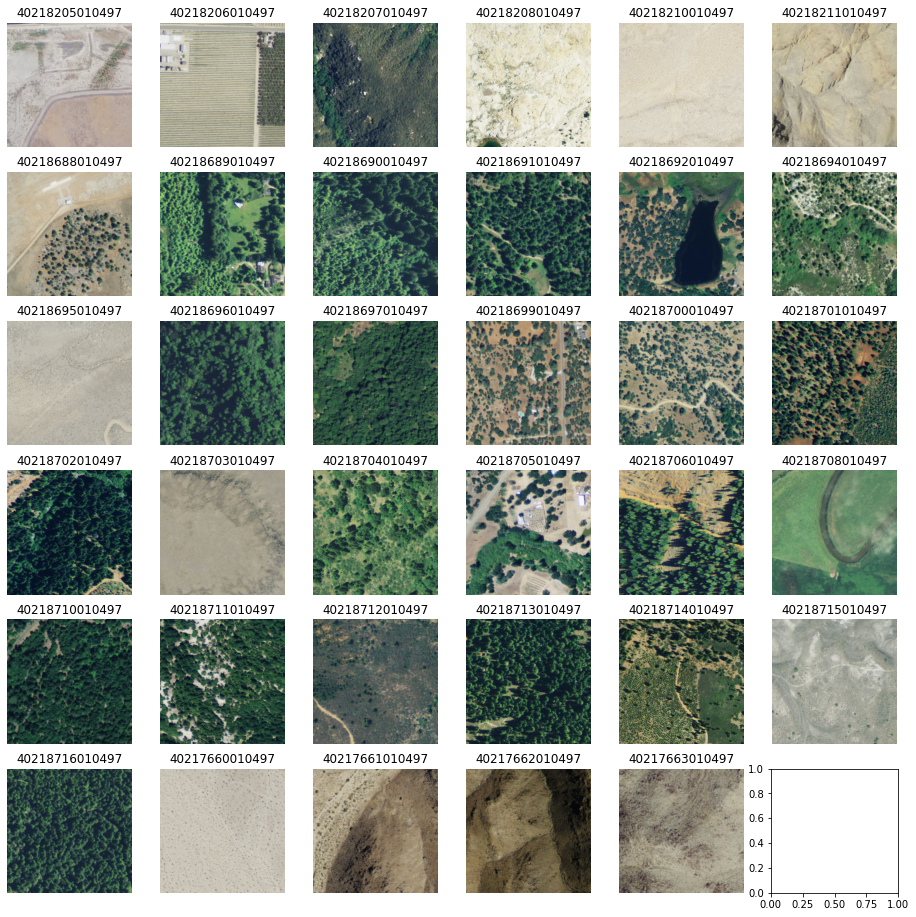

In [26]:

fig, axs = plt.subplots(6, 6, figsize=(16,16), edgecolor='k')
axs = axs.flatten()

for i in range(36):
    axs[i].imshow(image_crops[i][:,:,:3])
    axs[i].axis('off')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].set_aspect('equal')
    axs[i].set_title(labels[i])

plt.suptitle(f'A sample from {query}', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()
plt.close()


In [8]:
subdf['PLT_CN'] = subdf['PLT_CN'].astype('str')
batch_size = 25
subset = subdf.iloc[:batch_size]
KEYSIZE = 16
import random 
random.seed(1337)
uid = [str(binascii.hexlify(os.urandom(KEYSIZE)), 'utf-8')
        for i in range(batch_size)]
subset['UNIQID'] = uid

# let's run a sample for all the NAIP first and see how many batches we can do it in

In [9]:
#subsetting here would also be by ecoregion...
BUFFER = 128
roi, center = tools.get_points_centroid(subset)
uniqid = 'PLT_CN'
p = tools.generate_ee_points(subset[[uniqid, 'geometry']], idname=uniqid)
boxes = generate_box_buffer(subset, BUFFER, idname=uniqid)
fc_boxes = boxes['ee_fc']
box = boxes['box_df']

training_list = fc_boxes.toList(fc_boxes.size())
training_pnts = p.toList(p.size())

map_ex = folium.Map(center,zoom_start=4)
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(map_ex)
#add points
mc = MarkerCluster()
for _,p in subset.iterrows():
    mc.add_child(folium.Marker(location=[p.geometry.y,p.geometry.x],popup=p[uniqid]))
map_ex.add_child(mc)

#add boxes
[folium.GeoJson(geom).add_to(map_ex) for geom in box.geometry]
map_ex

# we want to filter each of the FIA points by year and group them into batches

In [ ]:
# set a year range based on the rules stipulated in the Chimera paper are:
# 2 years back and 1 year forward

req = '0001'
years = np.unique(geo_df.INVYR).astype(int)
RGB_bands = ['R','G','B'] #RGB
BUCKET = 'usfs-fia-data'
FOLDER = f'request-{req}'
BATCHES = 2
BUFFER = 60
#for y in years:
y = query_invyr
#    subset, _, _ = tools.create_subset(geo_df, y)
n = len(subset)
#subset the points first to get the appropriate images for plot
TRAINING_BASE = f'naip_{y}'
SAMPLE = f'sample_patches_{y}'
batch_indicies = np.array_split(np.arange(n),BATCHES)
for b in range(BATCHES):
    batch_subset, roi, training_pnts = tools.create_subset(subset.iloc[batch_indicies[b]], y)
    start_date = f'{y}-01-01'
    end_date = f'{y}-12-31'
    ic = ee.ImageCollection("USDA/NAIP/DOQQ")\
                   .filterBounds(roi)\
                   .filterDate(start_date, end_date)\
                   .select(RGB_bands).median()
    #if not ic.getInfo()['bands']:
    #    continue
    year_bands = [f'{b}_{y}' for b in RGB_bands]
    outimage = [ic.rename(year_bands)]
    featureStack = ee.Image.cat(outimage)

    arrays, EXPORT_BANDS = tools.create_arraystack(featureStack, BUFFER)

    n = training_pnts.size().getInfo()
    #we can batch here
    geomSample = ee.FeatureCollection([])
    for g in range(n):
        region = ee.Feature(training_pnts.get(g)).geometry()
        sample = arrays.sample(\
                               region = region,\
                               scale = 1,\
                               numPixels = 1,\
                               tileScale=8)
    geomSample = geomSample.merge(sample)
    desc = f'{TRAINING_BASE}_batch_{b+1}'
    task = ee.batch.Export.table.toCloudStorage(\
        collection = geomSample,\
        description = desc, \
        bucket = BUCKET,\
        fileNamePrefix = f'{FOLDER}/{desc}',\
        fileFormat = 'TFRecord',\
        selectors = EXPORT_BANDS)
    task.start()


In [ ]:
import os
creds = '/content/authentication/microsoft-aiforearth-f3c5b0f10cfa.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=creds
from google.cloud import storage
client = storage.Client()
bucket = storage.Bucket(BUCKET)
for blob in client.list_blobs(BUCKET):
    print(blob.name)

In [ ]:
import tensorflow as tf

In [ ]:
import subprocess
#command to get data
local_dirc = '/content/data'
cmd = f'gsutil -m cp -r gs://{BUCKET}/{FOLDER} {local_dirc}/'
print(cmd.split(' '))
subprocess.run(cmd.split(' '))

# `naip` in now a list of naip images for that year surrounding points that are of interest
# note that many times, these images may be blank as there are no images for the selected states within the roi 

In [ ]:
arrays, EXPORT_BANDS = tools.create_arraystack(featureStack, BUFFER)

In [ ]:
years = np.unique(geo_df.INVYR).astype(int)
BUCKET = 'usfs-fia-data'
FOLDER = 'aux-demo'
BATCHES = 3
KERNEL_SIZE = 12 
max_cloud_thr = 5
im_resolution = 30
BUFFER = 60

#we want to iterate through the years of the naip
for y in years:
    subset, _, _ = tools.create_subset(geo_df, y)
    n = len(subset)
    #subset the points first to get the appropriate images for plot
    TRAINING_BASE = f'aux_{y}'
    SAMPLE = f'aux_sample_patches_{y}'
    batch_indicies = np.array_split(np.arange(n),BATCHES)
    for b in range(BATCHES):
        batch_subset, roi, training_pnts = tools.create_subset(subset.iloc[batch_indicies[b]], y)
        start_date = [int(y),6,1]
        imgs = tools.get_model_data(roi, start_date, monthwindow=1, \
                                    max_cloud_thr=max_cloud_thr)
        topo = imgs['topo']
        climate = imgs['climate']
        landsat = imgs['landsat']
        
        featureStack = ee.Image.cat([
           topo, \
           climate, \
           landsat]).float()
        
        #topo_bands = [f"{b['id']}_{y}" for b in topo.getInfo()['bands']]
        #landsat_bands = [f"{b['id']}_{y}" for b in landsat.getInfo()['bands']]
        #climate_bands = [f"{b['id']}_{y}" for b in climate.getInfo()['bands']]       
        arrays, EXPORT_BANDS = tools.create_arraystack(featureStack, BUFFER)

        n = training_pnts.size().getInfo()
        #we can batch here
        geomSample = ee.FeatureCollection([])
        for g in range(n):
            region = ee.Feature(training_pnts.get(g)).geometry()
            sample = arrays.sample(\
                                   region = region,\
                                   scale = im_resolution,\
                                   numPixels = 1,\
                                   tileScale=8)
        geomSample = geomSample.merge(sample)
        desc = f'{TRAINING_BASE}_batch_{b+1}'
        
        task = ee.batch.Export.table.toCloudStorage(\
            collection = geomSample,\
            description = desc, \
            bucket = BUCKET,\
            fileNamePrefix = f'{FOLDER}/{desc}',\
            fileFormat = 'TFRecord',\
            selectors = EXPORT_BANDS)
        task.start()

